In [1]:
import os
import json
import pandas as pd
from pathlib import Path
import pykakasi
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter

main_dir = "Datasets/JSUT-dataset"
kks = pykakasi.kakasi()

In [2]:
data_dict = {}
for path in Path(main_dir).rglob('transcript_utf8.txt'):
    series = str(path).split("\\")[2]
    with open(path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            filename, kanji = line.strip("\n").split(":")
            hiragana = " ".join([word['hira'] for word in kks.convert(kanji)])
            romaji = " ".join([word['hepburn'] for word in kks.convert(kanji)])
            sub_dict = {f"{filename}": (series, kanji, hiragana, romaji)}
            data_dict.update(sub_dict)

data = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
data.columns = ['audio_file', 'series', 'kanji', 'hiragana', 'romaji']
data

,audio_file,series,kanji,hiragana,romaji
0,BASIC5000_0001,basic5000,水をマレーシアから買わなくてはならないのです。,みず を まれーしあ から かわ なくてはならないのです。,mizu wo mareeshia kara kawa nakutehanaranainod...
1,BASIC5000_0002,basic5000,木曜日、停戦会談は、何の進展もないまま終了しました。,もくようび、 ていせん かいだん は、 なんの しんてん もないまま しゅうりょう しました。,"mokuyoubi, teisen kaidan ha, nanno shinten mon..."
2,BASIC5000_0003,basic5000,上院議員は私がデータをゆがめたと告発した。,じょういん ぎいん は わたし が でーた をゆがめたと こくはつ した。,jouin giin ha watashi ga deeta woyugametato ko...
3,BASIC5000_0004,basic5000,１週間して、そのニュースは本当になった。,１ しゅうかん して、 その にゅーす は ほんとう になった。,"1 shuukan shite, sono nyuusu ha hontou ninatta."
4,BASIC5000_0005,basic5000,血圧は、健康のパロメーターとして重要である。,けつあつ は、 けんこう の ぱろめーたー として じゅうよう である。,"ketsuatsu ha, kenkou no paromeetaa toshite juu..."
...,...,...,...,...,...
7691,VOICEACTRESS100_096,voiceactress100,ペンシルベニア州、ピッツバーグの、アレゲーニー高校を卒業し、カリフォルニア大学、バークレー校...,ぺんしるべにあ しゅう、 ぴっつばーぐ の、 あれげーにー こうこう を そつぎょう し、 ...,"penshirubenia shuu, pittsubaagu no, aregeenii ..."
7692,VOICEACTRESS100_097,voiceactress100,この概念の導入によって、様々なバリエーションの、流体のコンピューターシミュレーションが、高い...,この がいねん の どうにゅう によって、 さまざまな ばりえーしょん の、 りゅうたい の...,"kono gainen no dounyuu niyotte, samazamana bar..."
7693,VOICEACTRESS100_098,voiceactress100,乾ドックに入渠して、オーバーホールすべきかどうか、パフォーマンスがチェックされた。,いぬい どっく に にゅうきょ して、 おーばーほーる すべきかどうか、 ぱふぉーまんす が...,"inui dokku ni nyuukyo shite, oobaahooru subeki..."
7694,VOICEACTRESS100_099,voiceactress100,デビューウェイトは、スーパーバンタム級ではなく、フェザー級だった。,でびゅーうぇいと は、 すーぱーばんたむ きゅう ではなく、 ふぇざー きゅう だった。,"debyuuueito ha, suupaabantamu kyuu dehanaku, f..."


## Preprocess .lab files

- Rescale time frames to samples
- Add end (`xx`) stamps

In [3]:
def preprocess_lab(in_path, out_path, wav_path):
    lines = []
    y, sr = librosa.load(wav_path, sr=librosa.get_samplerate(wav_path))
    with open(in_path, 'r') as f:
        text = f.readlines()
        for i, line in enumerate(text):
            start, end, context = line.split(" ")
            start = librosa.time_to_samples(int(start) / 1e7, sr=sr)
            end = librosa.time_to_samples(int(end) / 1e7, sr=sr)
            context = context.split('/')[0]
            context = context.split('-')[0]
            context = context.split('^')[1]
            context = context.strip("\n")
            line = " ".join([str(start), str(end), context])
            lines.append(line)
        if end < len(y):
            end_line = " ".join([str(end), str(len(y)), "xx"])
            lines.append(end_line)
        lines = "\n".join(lines)
    with open(out_path, 'w') as f:
        f.write(lines)
            
for filename, folder in tqdm(zip(data['audio_file'], data['series']), total=len(data)):
    in_folder = os.path.join(main_dir, folder, "lab")
    out_folder = os.path.join(main_dir, folder, "lab_cleaned")
    wav_folder = os.path.join(main_dir, folder, "wav")
    try:
        os.mkdir(out_folder)
    except:
        pass
    in_path = os.path.join(in_folder, filename) + ".lab"
    out_path = os.path.join(out_folder, filename) + ".lab"
    wav_path = os.path.join(wav_folder, filename) + ".wav"
    preprocess_lab(in_path, out_path, wav_path)

  0%|          | 0/7696 [00:00<?, ?it/s]

Romaji: genzai ha, bahha wo mochiifu toshita, haapushikoodo no sakkyokuka toshite, kioku sareteiru.


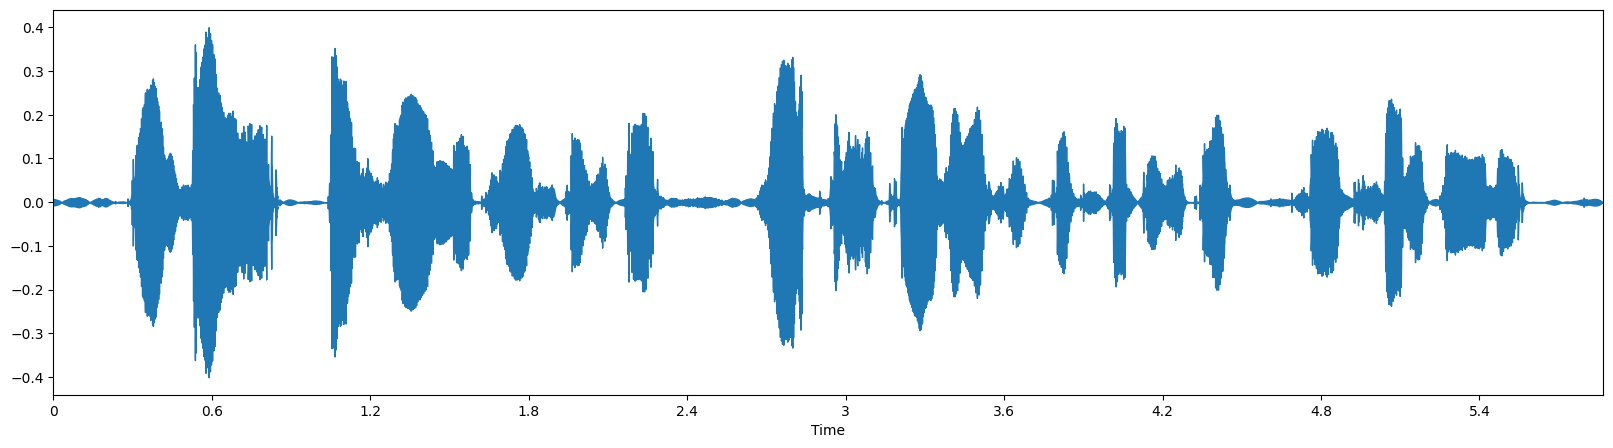

In [4]:
idx = 7684
filename = data['audio_file'][idx]
series = data['series'][idx]
wav_path = f"{main_dir}/{series}/wav/{filename}.wav"
lab_path = f"{main_dir}/{series}/lab/{filename}.lab"
print("Romaji:", data['romaji'][idx])

y, sr = librosa.load(wav_path, sr=librosa.get_samplerate(wav_path))

fig, ax = plt.subplots(figsize=(20, 5))
librosa.display.waveplot(y, sr=sr)
plt.show()

# Phonemes

In [ ]:
def get_phoneme(in_path):
    lines = []
    with open(in_path, 'r') as f:
        text = f.readlines()
        for i, line in enumerate(text):
            start, end, context = line.split(" ")
            context = context.strip("\n")
            lines.append(context)
        return lines

phonemes = []
for filename, folder in tqdm(zip(data['audio_file'], data['series']), total=len(data)):
    in_folder = os.path.join(main_dir, folder, "lab_cleaned")
    in_path = os.path.join(in_folder, filename) + ".lab"
    for j in get_phoneme(in_path):
        phonemes.append(j)

unique_phonemes = sorted(list(set(phonemes)))
print("Unique phonemes: \n", unique_phonemes)

In [ ]:
len(unique_phonemes)

# Morae

Mora was sorted by occurrence in corpus to reduce emphasis on common morae (`sil`, `pau`) by reducing their weights in the lexicon.

In [ ]:
vowels = ['a', 'e', 'i', 'o', 'u']
markers = ['sil', 'pau', 'xx', 'cl']
special = ['N']
consonants = [phoneme for phoneme in unique_phonemes if 
    phoneme not in (vowels + markers + special)]

print("Vowels:\n", vowels)
print("Consonants:\n", consonants)
print("Special:\n", special)
print("Markers:\n", markers)

In [ ]:
def get_mora(in_path):
    lines = []
    with open(in_path, 'r') as f:
        text = f.read().split("\n")
        i = 0
        while True:
            start_1, end_1, phoneme_1 = text[i].split(' ')
            if phoneme_1 in consonants: 
                start_2, end_2, phoneme_2 = text.pop(i+1).split(' ')
                mora =  (phoneme_1 + phoneme_2).lower()
                lines.append(mora)
            else:
                if phoneme_1 == 'o':
                    phoneme_1 = 'wo'
                lines.append(phoneme_1)
            if text[i] == text[-1]:
                break
            i += 1
    return lines

morae = []
for filename, folder in tqdm(zip(data['audio_file'], data['series']), total=len(data)):
    in_folder = os.path.join(main_dir, folder, "lab_cleaned")
    in_path = os.path.join(in_folder, filename) + ".lab"
    for j in get_mora(in_path):
        morae.append(j)

morae = sorted(Counter(morae), key=Counter(morae).get, reverse=True)
unique_morae = sorted(list(set(morae)))
print("Unique morae: \n", unique_morae)
morae_dict = {mora: i for i, mora in enumerate(morae)}

with open(f"{main_dir}/morae.json", "w") as f:
    json.dump(morae_dict, f, sort_keys=False, indent=4)

In [ ]:
def phoneme2mora(in_path):
    lines = []
    with open(in_path, 'r') as f:
        text = f.read().split("\n")
        i = 0
        while True:
            start_1, end_1, phoneme_1 = text[i].split(' ')
            if phoneme_1 in consonants: 
                start_2, end_2, phoneme_2 = text.pop(i+1).split(' ')
                mora =  (phoneme_1 + phoneme_2).lower()
                line = " ".join([str(start_1), str(end_2), mora])
                lines.append(line)
            else:
                if phoneme_1 == 'o':
                    phoneme_1 = 'wo'
                line = " ".join([str(start_1), str(end_1), phoneme_1])
                lines.append(line)
            if text[i] == text[-1]:
                break
            i += 1
    lines = "\n".join(lines)
    with open(in_path, 'w') as f:
        f.write(lines)

for filename, folder in tqdm(zip(data['audio_file'], data['series']), total=len(data)):
    in_folder = os.path.join(main_dir, folder, "lab_cleaned")
    in_path = os.path.join(in_folder, filename) + ".lab"
    phoneme2mora(in_path)

In [ ]:
# in_file = "Datasets\Youtube-audio-data\zWKBKKwyVrk.mp4"
# out_file = "zWKBKKwyVrk.ogg"

# subprocess.call([
#     "ffmpeg",
#     "-i",
#     in_file,
#     "-acodec",
#     "pcm_s16le",
#     "-ar",
#     "16000",
#     out_file
# ])

# subprocess.call([
#     "ffmpeg",
#     "-i",
#     in_file,
#     "-ar",
#     "40000",
#     out_file
# ])